In [1]:
from utils import read_MoGCN_data, setup_seed

SEED = 42

setup_seed(SEED)

# Data
path_1 = "data/fpkm_data.csv" # RNA-seq
path_2 = "data/gistic_data.csv" # CNV
path_3 = "data/rppa_data.csv" # RPPA
path_4 = "data/sample_classes.csv" # GT labels

omics_data = read_MoGCN_data([path_1, path_2, path_3])
gt_labels = read_MoGCN_data([path_4])[0]

for omics in omics_data:
    display(omics.head(5))

display(gt_labels.head(5))

,Sample,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,...,SLCO4C1,ARHGAP21,DDX47,POMZP3,SDS,TENM1,CYP4F2,PPP6R1,BATF3,OR8D4
0,A1-A0SF,2.067434,1.942403,3.560276,0.135735,7.743208,4.657533,1.223453,3.703006,2.805578,...,0.073609,2.762001,0.418301,3.851872,0.427608,0.094974,0.062719,4.067202,0.519763,0.0
1,A1-A0SJ,1.957792,1.300873,3.570082,0.069682,7.233006,5.461097,2.587125,3.860069,2.947874,...,0.524515,3.036548,0.133315,1.618410,0.839316,0.059009,0.038119,3.989149,0.261174,0.0
2,A1-A0SK,1.441807,3.745724,3.473475,0.109056,7.392388,4.063936,1.485730,3.576430,1.763526,...,2.022602,2.861571,0.961571,1.727583,1.018043,0.071582,0.013942,4.054611,1.266517,0.0
3,A1-A0SO,1.581208,2.554524,2.639751,0.004098,7.022142,6.033742,0.423807,2.604173,3.035735,...,1.356618,4.038301,0.385972,2.270792,2.287813,0.000000,0.000000,4.314811,0.163809,0.0
4,A1-A0SQ,3.570000,0.833485,2.794719,0.027372,7.337590,5.197790,0.830401,3.415020,3.195351,...,0.014459,2.211102,0.283034,2.602026,1.898632,0.007992,0.177719,2.928022,0.236619,0.0


,Sample,CDK11A,NADK,PRKCZ,GNB1,SDF4,DVL1,MORN1,INTS11,ACAP3,...,CTAG1A,H2AB1,F8A2,F8A3,F8A1,H2AB3,H2AB2,VAMP7,IL9R,SPRY3
0,A1-A0SF,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
1,A1-A0SJ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1-A0SK,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,A1-A0SO,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
4,A1-A0SQ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Sample,1433EPSILON,4EBP1,4EBP1_pS65,4EBP1_pT37T46,53BP1,ACC_pS79,ACC1,AKT,AKT_pS473,...,CHK1_pS296,COG3,DUSP4,ERCC5,IGF1R_pY1135Y1136,IRF1,JAK2,P16INK4A,SHP2_pY542,PDL1
0,A1-A0SF,-0.148050,0.280690,-0.206830,0.043661,0.007723,0.73249,0.36581,0.208970,-0.045389,...,-0.071920,0.255390,-0.197090,-0.042783,0.141100,-0.217300,-0.25174,0.174450,0.466370,0.020988
1,A1-A0SJ,0.236960,0.042512,-0.457350,-1.223800,-0.547510,0.35451,0.53247,0.079631,-0.677940,...,-0.254350,0.072076,-0.002982,-0.314790,0.267130,-0.157570,-0.52982,-0.009733,-0.259160,-0.060324
2,A1-A0SK,0.150320,2.264300,0.142840,1.114100,-0.321170,-0.69511,-0.55695,-0.081085,-0.997410,...,0.176010,0.089467,0.053083,0.438920,0.197530,-0.278500,-0.26498,1.235200,-0.044446,0.115520
3,A1-A0SO,-0.036329,0.179690,-0.088921,0.501620,-0.207150,0.79851,0.77029,0.548290,-0.524630,...,-0.065632,0.141780,0.186250,0.161400,-0.037196,0.015418,-0.26554,1.483400,-0.242920,0.108910
4,A1-A0SQ,-0.130740,-0.159870,-0.285990,-0.622760,0.207640,1.57060,1.27410,0.273420,-0.809150,...,0.056449,0.296530,0.797560,-0.276720,0.062988,-0.041233,-0.31501,-0.345480,-0.285560,-0.025572


,Sample,class,PAM50Call_RNAseq
0,A1-A0SF,0,LumA
1,A1-A0SJ,0,LumA
2,A1-A0SK,2,Basal
3,A1-A0SO,2,Basal
4,A1-A0SQ,0,LumA


epoch: 1 | loss: 57.7018
epoch: 20 | loss: 6.3388
epoch: 40 | loss: 5.4538
epoch: 60 | loss: 4.9172
epoch: 80 | loss: 4.5272
epoch: 100 | loss: 4.1400


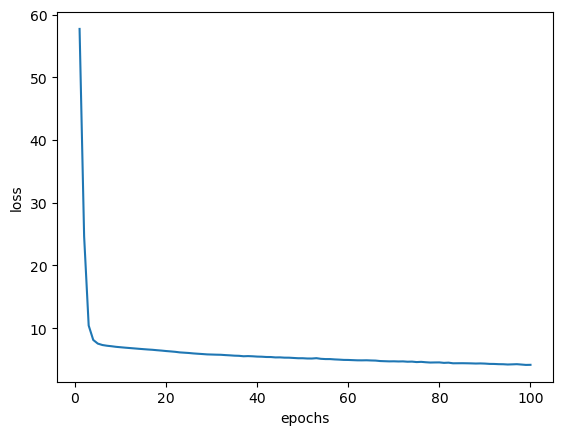

T-SNE KL Divergence:  1.1556227207183838


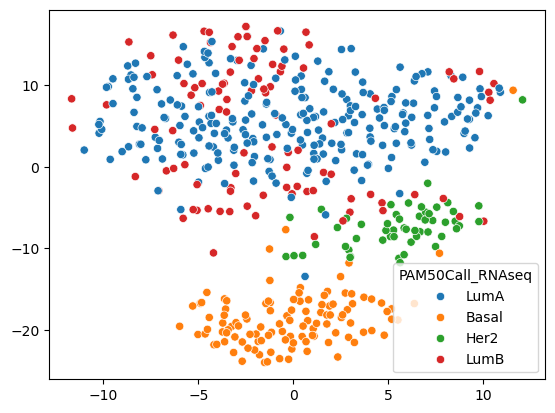

1.1556227207183838

In [12]:
import importlib
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import models
import train
import dataset

importlib.reload(models)
importlib.reload(train)
importlib.reload(dataset)

from models import MoGCN_VAE
from train import train_test, train_loop,save_latent_data
from dataset import  MoGCN_Dataset

DEVICE = torch.device("cuda")

# Train dataset
MoGCN_train = MoGCN_Dataset(omics_data, gt_labels)
train_loader = DataLoader(MoGCN_train, batch_size=32, shuffle=True)

# Model
model = MoGCN_VAE(
    MoGCN_train.input_dims, activation_fn=nn.Sigmoid(), dropout_p=0
)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
model.to(DEVICE)
model.train()
train_loss = train_loop(model, train_loader, optimizer, [nn.MSELoss(reduction="mean")]*3, 100)
save_latent_data(MoGCN_train, model)